In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os,gc,re,time
import matplotlib.pyplot as plt
import seaborn as sns
import spacy,random
from collections import Counter
import warnings,unicodedata
warnings.simplefilter("ignore")


#setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available device: {device}')

Available device: cuda


In [2]:
# colab
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/style_transfer')

Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv("data/tune.csv")
df

,formal,informal
0,"The In-Laws movie isn't a holiday movie, but i...",the movie The In-Laws not exactly a holiday mo...
1,I don't think that page gave me viruses.,that page did not give me viroses(i think)
2,"I watch it everyday, my favorite charachter is...","of corse i be wachin it evry day, my fav chara..."
3,Funbrain.com and runescape.com are great for f...,runescape.com (my kids love it) & funbrain.com...
4,He was on the Late Night show with Conan O'Bri...,Is he gay?He was on Late Night with Conan O'Br...
...,...,...
59995,"To get her to do what you want her to do, you ...",she is gonna do what she wants no matter what ...
59996,You get excited when you talk about him.,you sound like you like him a lot.
59997,I am a single woman.,"im single, but i'm a girl sry lol"
59998,"Just because he says it, doesn't mean that he ...","But, that does not mean he is in love, or love..."


In [76]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AdamW
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm

# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Load dataset
df = pd.read_csv("data/tune.csv")
input_texts = df['formal'].tolist()
target_texts = df['informal'].tolist()
df = pd.read_csv("data/tune_val.csv")
valid_input = df['formal'].tolist()
valid_target = df['informal'].tolist()

In [52]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, inputs, targets, max_len=512):
        self.tokenizer = tokenizer
        self.inputs = inputs
        self.targets = targets
        self.max_len = max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        input_encoding = tokenizer(
            input_text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt"
        )
        target_encoding = tokenizer(
            target_text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt"
        )

        return {
            'input_ids': input_encoding['input_ids'].flatten(),
            'attention_mask': input_encoding['attention_mask'].flatten(),
            'labels': target_encoding['input_ids'].flatten()
        }


In [77]:
# DataLoader
dataset = CustomDataset(tokenizer, input_texts, target_texts)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Validation data
dataset_valid = CustomDataset(tokenizer, valid_input, valid_target)
loader_valid = DataLoader(dataset_valid, batch_size=8, shuffle=True)
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

accumulation_steps = 1  # Adjust as needed
train_losses = []
valid_losses = []
for epoch in range(3):  # Number of training epochs
    # Training Phase
    model.train()
    train_progress_bar = tqdm(loader, desc=f"Training Epoch {epoch + 1}")
    total_train_loss = 0
    for batch in train_progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_progress_bar.set_postfix({'loss': loss.item()})
    train_losses.append(total_train_loss / len(loader))

    # Validation Phase
    model.eval()
    val_progress_bar = tqdm(loader_valid, desc=f"Validation Epoch {epoch + 1}")
    total_val_loss = 0
    for batch in val_progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

        val_progress_bar.set_postfix({'validation loss': loss.item()})
    valid_losses.append(total_val_loss / len(loader_valid))

    avg_val_loss = total_val_loss / len(loader_valid)
    print(f"Average Validation Loss for Epoch {epoch + 1}: {avg_val_loss}")




# Save the fine-tuned model
model_save_path = 'results/tune_model.pt'
torch.save(model.state_dict(), model_save_path)

Validation Epoch 1: 100%|██████████| 63/63 [00:14<00:00,  4.47it/s, validation loss=0.0801]


Average Validation Loss for Epoch 1: 0.11164402583288768


Validation Epoch 2: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s, validation loss=0.0539]


Average Validation Loss for Epoch 2: 0.08066440426877566


Validation Epoch 3: 100%|██████████| 63/63 [00:14<00:00,  4.49it/s, validation loss=0.0298]


Average Validation Loss for Epoch 3: 0.07600232710440953


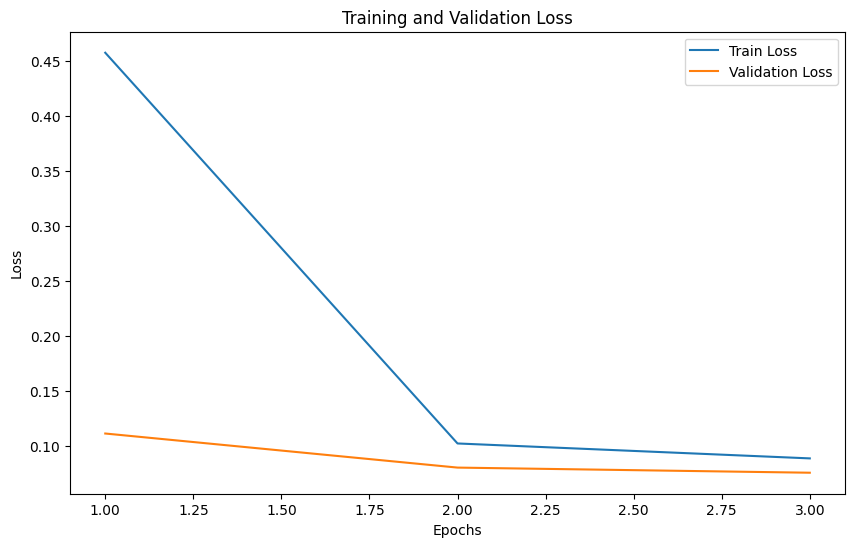

In [78]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs,train_losses, label='Train Loss')
plt.plot(epochs,valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [47]:
def generate_prediction(input_text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(inputs, max_length=40, num_beams=5, early_stopping=True)
        print(outputs)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [79]:
#model.load_state_dict(torch.load(model_save_path))
#model.to(device)

test_sentence = "A man walks by a silver vehicle."
input_ids = tokenizer.encode(test_sentence, return_tensors="pt")
input_ids = input_ids.to(device)
print(input_ids)
output_ids = model.generate(input_ids)
output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(output)

tensor([[   71,   388, 10681,    57,     3,     9,  4294,  1689,     5,     1]],
       device='cuda:0')
a man walks by a silver vehicle
